In [ ]:
Выполнил: Кузьмин Андрей, tg: @thisismoto

https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview

## Import

In [3]:
!pip install lightautoml[nlp]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.6/399.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7594 sha256=f97655e541835220175e3e0e1abe6d3cb7c249b6698fdf98a79f533bc14abfc6
  Stor

In [4]:
import shutil

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import LimeTextExplainer, L2XTextExplainer

import transformers
transformers.logging.set_verbosity(50)

import pickle

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Data

In [5]:
!unzip jigsaw-toxic-comment-classification-challenge.zip
!unzip train.csv.zip
!unzip test.csv.zip
!unzip sample_submission.csv.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [99]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

In [14]:
subm = test.merge(subm, on='id')

In [95]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0
159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0
60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0
65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0
154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0


In [96]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
131631,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
125326,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
111256,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
83590,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0


In [97]:
subm.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.5,0.5,0.5,0.5,0.5,0.5


In [102]:
train['comment_text'][140030]

'Grandma Terri Should Burn in Trash \nGrandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40'

In [104]:
train['comment_text'].tail()

,comment_text
119879,REDIRECT Talk:John Loveday (experimental physi...
103694,Back it up. Post the line here with the refere...
131932,I won't stop that. Sometimes Germanic equals G...
146867,"""\n\n British Bands? \n\nI think you've mista..."
121958,You are WRONG. \n\nJustin Thompson is mentione...


In [105]:
train['comment_text'][103694]

'Back it up. Post the line here with the reference.'

In [106]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(395.248276618412, 593.4303724527018, 5000)

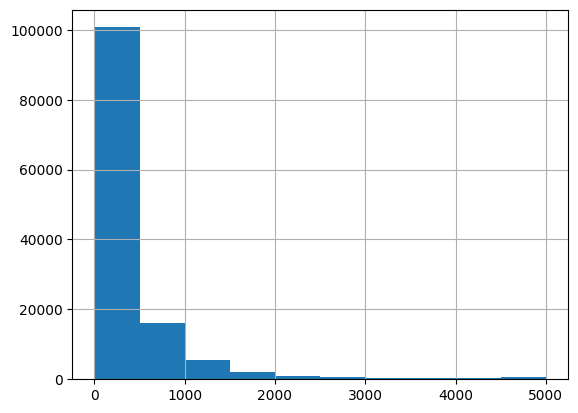

In [107]:
lens.hist();

In [108]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,127656.000000,127656.00000,127656.000000,127656.000000,127656.000000,127656.000000,127656.000000
mean,0.095867,0.00998,0.052751,0.003165,0.049062,0.008703,0.898313
std,0.294410,0.09940,0.223537,0.056167,0.215997,0.092884,0.302238
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
len(train), len(test)

(127656, 153164)

## Automl binary

### Toxic model

In [15]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    'target': 'toxic'
}

task = Task('binary')

automl_toxic = TabularNLPAutoML(
    task=task,
    timeout=900,
    cpu_limit=2,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 2,
    }

)


In [16]:
%%time
oof_pred_toxic = automl_toxic.fit_predict(train, roles=roles, verbose = 10)
test_pred_toxic = automl_toxic.predict(test)

[12:28:54] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[12:28:54] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[12:28:54] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[12:28:54] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[12:28:54] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[12:28:54] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[12:28:54] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[12:28:54] Train data shape: (127656, 8)



INFO:lightautoml.reader.base:Train data shape: (127656, 8)



[12:28:54] Layer 1 train process start. Time left 899.88 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 899.88 secs


[12:28:55] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[12:28:55] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[12:28:55] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[12:28:55] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[12:28:55] Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'>

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mode

[12:28:55] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

[12:29:03] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[12:33:05] Epoch: 0, train loss: 0.6413275003433228, val loss: 0.5243892073631287, val metric: 0.9524577079740194


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.6413275003433228, val loss: 0.5243892073631287, val metric: 0.9524577079740194


[12:36:50] Epoch: 1, train loss: 0.5678825378417969, val loss: 0.5338758230209351, val metric: 0.9635760658885097


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 0.5678825378417969, val loss: 0.5338758230209351, val metric: 0.9635760658885097


[12:36:51] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[12:36:52] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[12:40:59] Epoch: 0, train loss: 0.6419970393180847, val loss: 0.5442343354225159, val metric: 0.9544568486426299


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.6419970393180847, val loss: 0.5442343354225159, val metric: 0.9544568486426299


[12:45:02] Epoch: 1, train loss: 0.5654829144477844, val loss: 0.5336108207702637, val metric: 0.9632351765596996


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 0.5654829144477844, val loss: 0.5336108207702637, val metric: 0.9632351765596996


[12:45:03] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[12:45:03] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9633373755546711


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9633373755546711


[12:45:03] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[12:45:03] Time left -69.45 secs



INFO:lightautoml.automl.base:Time left -69.45 secs



[12:45:03] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[12:45:03] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[12:45:03] Automl preset training completed in 969.46 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 969.46 seconds



[12:45:03] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[12:45:04] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[12:46:04] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


NameError: name 'sumb' is not defined

In [28]:
not_nan = np.any(~np.isnan(oof_pred_toxic.data), axis=1)

sumb_toxic = automl_toxic.predict(subm)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred_toxic.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred_toxic.data[:, 0])))

INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False
INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


Check scores:
OOF score: 0.9633373755546711
TEST score: 0.9604387209231234


In [56]:
pd.DataFrame(sumb_toxic.data).to_csv('sumb_toxic.csv', index=False)

### Severe_toxic model

In [38]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id', 'toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    'target': 'severe_toxic'
}

task = Task('binary')

automl_severe_toxic = TabularNLPAutoML(
    task=task,
    timeout=900,
    cpu_limit=2,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 2,
    }

)


In [39]:
%%time
oof_pred_severe_toxic = automl_severe_toxic.fit_predict(train, roles=roles, verbose = 10)
test_pred_severe_toxic = automl_severe_toxic.predict(test)
not_nan = np.any(~np.isnan(oof_pred_severe_toxic.data), axis=1)

sumb_severe_toxic = automl_severe_toxic.predict(subm)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred_severe_toxic.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred_severe_toxic.data[:, 0])))

[13:05:23] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[13:05:23] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[13:05:23] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[13:05:23] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[13:05:23] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[13:05:23] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[13:05:23] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[13:05:23] Train data shape: (127656, 8)



INFO:lightautoml.reader.base:Train data shape: (127656, 8)



[13:05:23] Layer 1 train process start. Time left 899.92 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 899.92 secs


[13:05:23] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[13:05:23] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[13:05:23] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[13:05:23] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[13:05:23] Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'>

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mode

[13:05:23] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[13:05:24] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:09:15] Epoch: 0, train loss: 0.7624977231025696, val loss: 0.7148200869560242, val metric: 0.9617417369973988


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7624977231025696, val loss: 0.7148200869560242, val metric: 0.9617417369973988


[13:13:01] Epoch: 1, train loss: 0.7241961359977722, val loss: 0.6814936995506287, val metric: 0.97614849891436


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 0.7241961359977722, val loss: 0.6814936995506287, val metric: 0.97614849891436


[13:13:01] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[13:13:02] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:16:44] Epoch: 0, train loss: 0.7618426084518433, val loss: 0.6921765804290771, val metric: 0.9681058535883791


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7618426084518433, val loss: 0.6921765804290771, val metric: 0.9681058535883791


[13:20:33] Epoch: 1, train loss: 0.7246556282043457, val loss: 0.7113555073738098, val metric: 0.9784414075645212


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 0.7246556282043457, val loss: 0.7113555073738098, val metric: 0.9784414075645212


[13:20:33] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[13:20:33] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9771130309378975


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9771130309378975


[13:20:33] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[13:20:33] Time left -10.33 secs



INFO:lightautoml.automl.base:Time left -10.33 secs



[13:20:33] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[13:20:33] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[13:20:33] Automl preset training completed in 910.34 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 910.34 seconds



[13:20:33] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[13:20:34] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:21:34] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:22:27] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:26:30] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


Check scores:
OOF score: 0.9771130309378975
TEST score: 0.9767000990171839
CPU times: user 4min 30s, sys: 17.8 s, total: 4min 48s
Wall time: 25min


In [55]:
pd.DataFrame(sumb_severe_toxic.data).to_csv('sumb_severe_toxic.csv', index=False)

### Obscene model

In [41]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id', 'toxic', 'severe_toxic', 'threat', 'insult', 'identity_hate'],
    'target': 'obscene'
}

task = Task('binary')

automl_obscene = TabularNLPAutoML(
    task=task,
    timeout=900,
    cpu_limit=2,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 2,
    }

)


In [42]:
%%time
oof_pred_obscene = automl_obscene.fit_predict(train, roles=roles, verbose = 10)
test_pred_obscene = automl_obscene.predict(test)
not_nan = np.any(~np.isnan(oof_pred_obscene.data), axis=1)

sumb_obscene = automl_obscene.predict(subm)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred_obscene.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred_obscene.data[:, 0])))

[13:30:24] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[13:30:24] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[13:30:24] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[13:30:24] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[13:30:24] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[13:30:24] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[13:30:24] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[13:30:24] Train data shape: (127656, 8)



INFO:lightautoml.reader.base:Train data shape: (127656, 8)



[13:30:24] Layer 1 train process start. Time left 899.91 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 899.91 secs


[13:30:24] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[13:30:24] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[13:30:24] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[13:30:24] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[13:30:24] Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'>

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mode

[13:30:24] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[13:30:25] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:34:03] Epoch: 0, train loss: 0.6797207593917847, val loss: 0.5718210935592651, val metric: 0.966413324398566


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.6797207593917847, val loss: 0.5718210935592651, val metric: 0.966413324398566


[13:37:40] Epoch: 1, train loss: 0.6129001975059509, val loss: 0.5596133470535278, val metric: 0.9784126132522889


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 0.6129001975059509, val loss: 0.5596133470535278, val metric: 0.9784126132522889


[13:37:41] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[13:37:41] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:41:20] Epoch: 0, train loss: 0.6775449514389038, val loss: 0.5558379292488098, val metric: 0.9635759686941698


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.6775449514389038, val loss: 0.5558379292488098, val metric: 0.9635759686941698


[13:44:56] Epoch: 1, train loss: 0.611206591129303, val loss: 0.5720446109771729, val metric: 0.9740437796924197


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 0.611206591129303, val loss: 0.5720446109771729, val metric: 0.9740437796924197


[13:44:57] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[13:44:57] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9760937854290586


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9760937854290586


[13:44:57] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[13:44:57] Time left 26.84 secs



INFO:lightautoml.automl.base:Time left 26.84 secs



[13:44:57] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[13:44:57] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[13:44:57] Automl preset training completed in 873.18 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 873.18 seconds



[13:44:57] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[13:44:58] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:45:48] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:46:39] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:50:28] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


Check scores:
OOF score: 0.9760937854290586
TEST score: 0.9712044388237793
CPU times: user 4min 26s, sys: 17.5 s, total: 4min 44s
Wall time: 23min 54s


In [54]:
pd.DataFrame(sumb_obscene.data).to_csv('sumb_obscene.csv', index=False)

### Insult model

In [60]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'identity_hate'],
    'target': 'insult'
}

task = Task('binary')

automl_insult = TabularNLPAutoML(
    task=task,
    timeout=900,
    cpu_limit=2,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 1,
    }

)


In [61]:
%%time
oof_pred_insult = automl_insult.fit_predict(train, roles=roles, verbose = 10)
test_pred_insult = automl_insult.predict(test)
not_nan = np.any(~np.isnan(oof_pred_insult.data), axis=1)

sumb_insult = automl_insult.predict(subm)


print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred_insult.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred_insult.data[:, 0])))

[14:07:33] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[14:07:33] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[14:07:33] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:07:33] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:07:33] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[14:07:33] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[14:07:33] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:07:33] Train data shape: (127656, 8)



INFO:lightautoml.reader.base:Train data shape: (127656, 8)



[14:07:33] Layer 1 train process start. Time left 899.92 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 899.92 secs


[14:07:33] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[14:07:33] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[14:07:33] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[14:07:33] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[14:07:33] Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 1, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'>

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 1, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mode

[14:07:33] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[14:07:34] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:11:31] Epoch: 0, train loss: 0.6952386498451233, val loss: 0.5775730013847351, val metric: 0.9512137205181429


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.6952386498451233, val loss: 0.5775730013847351, val metric: 0.9512137205181429


[14:11:31] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[14:11:32] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:15:23] Epoch: 0, train loss: 0.6960780024528503, val loss: 0.600500762462616, val metric: 0.9552506714733611


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.6960780024528503, val loss: 0.600500762462616, val metric: 0.9552506714733611


[14:15:23] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[14:15:24] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:19:32] Epoch: 0, train loss: 0.695831835269928, val loss: 0.6240615844726562, val metric: 0.953731097856815


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.695831835269928, val loss: 0.6240615844726562, val metric: 0.953731097856815


[14:19:33] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9526995300188728


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9526995300188728


[14:19:33] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[14:19:33] Time left 180.06 secs



INFO:lightautoml.automl.base:Time left 180.06 secs



[14:19:33] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:19:33] Automl preset training completed in 719.96 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 719.96 seconds



[14:19:33] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[14:19:34] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:20:34] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:21:30] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:22:21] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:26:28] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:31:20] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


Check scores:
OOF score: 0.9526995300188728
TEST score: 0.9524418201075233
CPU times: user 4min 12s, sys: 19 s, total: 4min 31s
Wall time: 28min 24s


In [62]:
pd.DataFrame(sumb_insult.data).to_csv('sumb_insult.csv', index=False)

### Identity_hate model

In [63]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult'],
    'target': 'identity_hate'
}

task = Task('binary')

automl_identity_hate = TabularNLPAutoML(
    task=task,
    timeout=900,
    cpu_limit=2,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 1,
    }

)


In [64]:
%%time
oof_pred_identity_hate = automl_identity_hate.fit_predict(train, roles=roles, verbose = 10)
test_pred_identity_hate = automl_identity_hate.predict(test)
not_nan = np.any(~np.isnan(oof_pred_identity_hate.data), axis=1)

sumb_identity_hate = automl_identity_hate.predict(subm)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred_identity_hate.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred_identity_hate.data[:, 0])))

[14:35:58] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[14:35:58] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[14:35:58] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:35:58] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:35:58] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[14:35:58] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[14:35:58] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:35:58] Train data shape: (127656, 8)



INFO:lightautoml.reader.base:Train data shape: (127656, 8)



[14:35:58] Layer 1 train process start. Time left 899.92 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 899.92 secs


[14:35:58] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[14:35:58] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[14:35:58] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[14:35:58] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[14:35:58] Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 1, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'>

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 1, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mode

[14:35:58] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[14:35:59] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:39:39] Epoch: 0, train loss: 0.7784637212753296, val loss: 0.6959517598152161, val metric: 0.9399264704940111


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7784637212753296, val loss: 0.6959517598152161, val metric: 0.9399264704940111


[14:39:39] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[14:39:40] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:43:36] Epoch: 0, train loss: 0.7803735136985779, val loss: 0.6741276383399963, val metric: 0.9393030779107778


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7803735136985779, val loss: 0.6741276383399963, val metric: 0.9393030779107778


[14:43:37] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[14:43:37] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:47:36] Epoch: 0, train loss: 0.7776265740394592, val loss: 0.7059352993965149, val metric: 0.9409647846071648


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7776265740394592, val loss: 0.7059352993965149, val metric: 0.9409647846071648


[14:47:36] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9397952628642294


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9397952628642294


[14:47:36] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[14:47:36] Time left 201.48 secs



INFO:lightautoml.automl.base:Time left 201.48 secs



[14:47:36] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:47:36] Automl preset training completed in 698.54 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 698.54 seconds



[14:47:36] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[14:47:37] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:48:43] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:49:48] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:51:05] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:54:59] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[14:58:50] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


Check scores:
OOF score: 0.9397952628642294
TEST score: 0.9331304736562094
CPU times: user 4min 9s, sys: 18.9 s, total: 4min 28s
Wall time: 26min 45s


In [65]:
pd.DataFrame(sumb_identity_hate.data).to_csv('sumb_identity_hate.csv', index=False)

### Threat model

In [66]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id', 'toxic', 'severe_toxic', 'obscene', 'identity_hate', 'insult'],
    'target': 'threat'
}

task = Task('binary')

automl_threat = TabularNLPAutoML(
    task=task,
    timeout=900,
    cpu_limit=2,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 1,
    }

)


In [67]:
%%time
oof_pred_threat = automl_threat.fit_predict(train, roles=roles, verbose = 10)
test_pred_threat = automl_threat.predict(test)
not_nan = np.any(~np.isnan(oof_pred_threat.data), axis=1)

sumb_threat = automl_threat.predict(subm)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred_threat.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred_threat.data[:, 0])))

[15:02:43] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[15:02:43] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[15:02:43] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[15:02:43] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:02:43] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[15:02:43] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[15:02:43] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:02:43] Train data shape: (127656, 8)



INFO:lightautoml.reader.base:Train data shape: (127656, 8)



[15:02:43] Layer 1 train process start. Time left 899.92 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 899.92 secs


[15:02:44] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[15:02:44] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[15:02:44] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[15:02:44] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[15:02:44] Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 1, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'>

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 1, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mode

[15:02:44] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[15:02:44] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:06:21] Epoch: 0, train loss: 0.7895164489746094, val loss: 0.6870625615119934, val metric: 0.930821134790004


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7895164489746094, val loss: 0.6870625615119934, val metric: 0.930821134790004


[15:06:22] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[15:06:23] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:10:01] Epoch: 0, train loss: 0.7894597053527832, val loss: 0.7486295104026794, val metric: 0.9032832747876246


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7894597053527832, val loss: 0.7486295104026794, val metric: 0.9032832747876246


[15:10:02] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[15:10:03] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:13:40] Epoch: 0, train loss: 0.7903108596801758, val loss: 0.7048534750938416, val metric: 0.9323143498544869


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 0.7903108596801758, val loss: 0.7048534750938416, val metric: 0.9323143498544869


[15:13:41] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9191410323882166


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.9191410323882166


[15:13:41] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[15:13:41] Time left 242.29 secs



INFO:lightautoml.automl.base:Time left 242.29 secs



[15:13:41] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:13:41] Automl preset training completed in 657.72 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 657.72 seconds



[15:13:41] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[15:13:42] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:14:33] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:15:23] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:16:15] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:20:07] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:23:58] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


Check scores:
OOF score: 0.9191410323882166
TEST score: 0.9314079161916855
CPU times: user 4min 7s, sys: 18.3 s, total: 4min 25s
Wall time: 25min 3s


In [68]:
pd.DataFrame(sumb_threat.data).to_csv('sumb_threat.csv', index=False)

### Merge subm

In [74]:
result = pd.read_csv('sample_submission.csv')

result['threat'] = sumb_threat.data
result['severe_toxic'] = sumb_severe_toxic.data
result['toxic'] = sumb_toxic.data
result['obscene'] = sumb_obscene.data
result['insult'] = sumb_insult.data
result['identity_hate'] = sumb_identity_hate.data

result.to_csv('sumb_binary.csv', index=False)

In [75]:
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.991064,0.995989,0.992621,0.827358,0.996373,0.998123
1,0000247867823ef7,0.407244,0.435450,0.431209,0.407637,0.438429,0.381124
2,00013b17ad220c46,0.447829,0.435964,0.454814,0.351706,0.441151,0.349259
3,00017563c3f7919a,0.381211,0.437420,0.414000,0.408708,0.413102,0.441688
4,00017695ad8997eb,0.422219,0.447269,0.435335,0.434344,0.452779,0.469081


## Automl multilabels

In [76]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'],
    'drop': ['id'],
    'target': ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
}

task = Task('multilabel')

automl = TabularNLPAutoML(
    task=task,
    timeout=900,
    cpu_limit=2,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 2,
    }

)


multilabel isn`t supported in lgb
[15:31:07] CatBoost uses as obj. MultiCrossEntropy.


INFO2:lightautoml.tasks.losses.cb:CatBoost uses as obj. MultiCrossEntropy.


multilabel isn`t supported in xgb


In [77]:
%%time
oof_pred = automl.fit_predict(train, roles=roles, verbose = 10)
test_pred = automl.predict(test)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

[15:31:12] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[15:31:12] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[15:31:12] Task: multilabel



INFO:lightautoml.automl.presets.base:Task: multilabel



[15:31:12] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:31:12] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[15:31:12] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[15:31:12] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:31:12] Train data shape: (127656, 8)



INFO:lightautoml.reader.base:Train data shape: (127656, 8)



[15:31:12] Layer 1 train process start. Time left 899.93 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 899.93 secs


[15:31:13] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[15:31:13] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[15:31:13] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[15:31:13] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[15:31:13] Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'>

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 2, 'pin_memory': False, 'max_length': 128, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 2, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 32, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mode

[15:31:13] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[15:31:14] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:35:19] Epoch: 0, train loss: 4.403194427490234, val loss: 3.86201548576355, val metric: -0.0545819964415064


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 4.403194427490234, val loss: 3.86201548576355, val metric: -0.0545819964415064


[15:39:33] Epoch: 1, train loss: 4.092041492462158, val loss: 3.868513822555542, val metric: -0.04869413448902502


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 4.092041492462158, val loss: 3.868513822555542, val metric: -0.04869413448902502


[15:39:33] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[15:39:34] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:43:22] Epoch: 0, train loss: 4.4016852378845215, val loss: 3.8507299423217773, val metric: -0.045373171884618035


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 4.4016852378845215, val loss: 3.8507299423217773, val metric: -0.045373171884618035


[15:47:04] Epoch: 1, train loss: 4.0943603515625, val loss: 3.7251954078674316, val metric: -0.04070881142414933


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 4.0943603515625, val loss: 3.7251954078674316, val metric: -0.04070881142414933


[15:47:05] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[15:47:05] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = -0.044701472956587184


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = -0.044701472956587184


[15:47:05] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[15:47:05] Time left -53.23 secs



INFO:lightautoml.automl.base:Time left -53.23 secs



[15:47:05] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[15:47:05] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:47:05] Automl preset training completed in 953.24 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 953.24 seconds



[15:47:05] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[15:47:06] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:48:02] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:48:54] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:52:50] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


CPU times: user 4min 31s, sys: 18.3 s, total: 4min 49s
Wall time: 25min 28s


In [92]:
sumb_miltilabels = automl.predict(subm)

[16:02:53] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[16:06:49] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


In [93]:
sumb_miltilabels.data

array([[0.9828239 , 0.9846284 , 0.98962   , 0.49833217, 0.9837056 ,
        0.9787377 ],
       [0.37272438, 0.4439507 , 0.41867036, 0.4061284 , 0.41787496,
        0.4060862 ],
       [0.43483812, 0.44307137, 0.39727253, 0.48903686, 0.40749156,
        0.38027114],
       ...,
       [0.38034922, 0.41815567, 0.4196272 , 0.41462255, 0.4049163 ,
        0.36485583],
       [0.3572696 , 0.41791344, 0.40526015, 0.47089985, 0.39995384,
        0.38802055],
       [0.980477  , 0.9126931 , 0.967576  , 0.56080574, 0.9613559 ,
        0.9562428 ]], dtype=float32)

In [94]:
result = pd.read_csv('sample_submission.csv')

result[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = sumb_miltilabels.data

result.to_csv('sumb_miltilabels.csv', index=False)

## Logistic regression with TF-IDF

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

In [7]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)

In [8]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

<ipython-input-8-d2957acc749a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[COMMENT].fillna("unknown", inplace=True)
<ipython-input-8-d2957acc749a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [9]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [13]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=True,
               smooth_idf=True, sublinear_tf=True )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

In [15]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [16]:
x = trn_term_doc
test_x = test_term_doc

In [19]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=False)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [20]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [21]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission_tdidf.csv', index=False)

## Logistic regression with n-grams

In [22]:
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [23]:
train = pd.read_csv('train.csv').fillna(' ')
test = pd.read_csv('test.csv').fillna(' ')

In [24]:
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)

train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [ ]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [ ]:
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in label_cols:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

submission.to_csv('submission_n_grams.csv', index=False)